In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import datetime
import numpy as np
from datetime import timedelta
warnings.simplefilter(action='ignore', category=FutureWarning)

!pip install intervaltree
from intervaltree import Interval, IntervalTree

Defaulting to user installation because normal site-packages is not writeable


In [2]:
def to_seconds(s):
    hr, min, sec, ms = [float(x) for x in s.replace(",", ":").split(':')]
    return hr*3600 + min*60 + sec + ms*0.001

def to_tuples(lst):
    a = []
    for x in lst:
        b = []
        for elem in x:
            elem = to_seconds(elem)
            b.append(elem)
        a.append(b)
    return (a)

In [3]:
def get_subtitles(movie_name):
    filename= '/scratch/elec/puhe/c/momaf/subtitles/' + movie_name + '.srt'
    with open(filename) as f:
        lines = f.readlines()
        
    desired_lines = []
    for line in lines:
        if "-->" in line:
            sen1 = line.split(' \n')[0]
            sen2 = sen1.split(' --> ')
            
            desired_lines.append(sen2)
            #desired_lines.append(line)
            
    
    return to_tuples(desired_lines)
        

In [4]:
def format_result(result):
    seconds = int(result)
    microseconds = (result * 1000000) % 1000000
    output = timedelta(0, seconds, microseconds)
    return output

print (format_result(121.44))

0:02:01.440000


In [5]:
def calculateStats(source, comparison):
    t1 = IntervalTree.from_tuples(source)
    
    tp = 0
    fp = 0
    
    for i in comparison:
        if len(sorted(t1[i[0]:i[1]])) > 0:
            tp += 1
        else:
            fp += 1
            
    t2 = IntervalTree.from_tuples(comparison)
    
    #tn = 0
    fn = 0
    
    for j in source:
        if len(sorted(t2[j[0]:j[1]])) == 0:
            fn += 1
            
    return (tp, fp, fn, tp/(tp+fp), tp/(tp+fn))

In [6]:
## read from batch file
batch_predictions_df = pd.read_csv('speech_predictions_batch.tsv', sep='\t')
 
# printing data
batch_predictions_df.head()

,index,event_label,onset,offset,filename
0,0,Speech,5.32,5.58,../test_data/123564-LaivastonMonnitMaissa-1954...
1,0,Speech,43.48,45.98,../test_data/125921-AnuJaMikko-1956.wav
2,1,Speech,47.40,47.90,../test_data/125921-AnuJaMikko-1956.wav
3,2,Speech,48.38,48.78,../test_data/125921-AnuJaMikko-1956.wav
4,3,Speech,48.92,49.86,../test_data/125921-AnuJaMikko-1956.wav


In [7]:
movie_dict = {}
for movie in batch_predictions_df.filename.unique():
    
    movie_df = batch_predictions_df[batch_predictions_df['filename'] == movie]
    
    predictions_list = list(zip(movie_df['onset'],movie_df['offset']))
    
    movie_dict[movie[13:-4]] = predictions_list

In [8]:
srt_dict = {}
for i in movie_dict.keys():
    try:
        srt_dict[i] = get_subtitles(i)
    except Exception:
        print ('File not found for movie ' + i)
        pass

File not found for movie 117408-Lasisydan-1959
File not found for movie 122603-SadanMiekanMies-1951-2
File not found for movie 117396-Sampo-1959-3
File not found for movie 122607-GabrielTuleTakaisin-1951-2


In [9]:
stu_result_df  = pd.DataFrame(columns = ['movie', 'tp', 'fp', 'fn' , 'precision' ,'recall', 'f1'])
for movie, timestamp in srt_dict.items():
    c1, c2, c3, c4, c5 = calculateStats(timestamp, movie_dict[movie])
    stu_result_df = stu_result_df.append({'movie': movie[:6], 'tp': c1, 'fp':c2 , 'fn' :c3, 'precision' :c4, 'recall': c5, 'f1': (2*c4*c5)/(c4+c5) }, ignore_index=True)

In [10]:
stu_result_df.sort_values(by=['movie'])

,movie,tp,fp,fn,precision,recall,f1
9,100455,1932,90,83,0.95549,0.958809,0.957146
23,107883,1105,31,54,0.972711,0.953408,0.962963
2,115715,1590,85,136,0.949254,0.921205,0.935019
24,115761,1753,4,178,0.997723,0.90782,0.950651
32,115770,1826,10,76,0.994553,0.960042,0.976993
8,115777,1243,40,54,0.968823,0.958365,0.963566
5,115808,1556,44,64,0.9725,0.960494,0.96646
17,115810,1199,19,46,0.984401,0.963052,0.973609
6,117285,2703,82,46,0.970557,0.983267,0.97687
4,117299,1198,64,88,0.949287,0.931571,0.940345


In [11]:
### for teacher
teacher_predictions_df = pd.read_csv('speech_predictions_teacher.tsv', sep='\t')
 
# printing data

teacher_predictions_df.head()

,index,event_label,onset,offset,filename
0,399,Speech,39.64,40.34,../test_data/125921-AnuJaMikko-1956.wav
1,400,Speech,41.36,46.12,../test_data/125921-AnuJaMikko-1956.wav
2,401,Speech,46.32,50.06,../test_data/125921-AnuJaMikko-1956.wav
3,739,Speech,49.68,49.90,../test_data/123144-Tukkijoella-1951.wav
4,402,Speech,50.90,51.10,../test_data/125921-AnuJaMikko-1956.wav


In [12]:
teacher_movie_dict = {}
for movie in teacher_predictions_df.filename.unique():
    
    movie_df = teacher_predictions_df[teacher_predictions_df['filename'] == movie]
    
    predictions_list = list(zip(movie_df['onset'],movie_df['offset']))
    
    teacher_movie_dict[movie[13:-4]] = predictions_list

In [13]:
teacher_srt_dict = {}
for i in teacher_movie_dict.keys():
    try:
        teacher_srt_dict[i] = get_subtitles(i)
    except Exception:
        print ('File not found for movie ' + i)
        pass

File not found for movie 117408-Lasisydan-1959
File not found for movie 122603-SadanMiekanMies-1951-2
File not found for movie 117396-Sampo-1959-3
File not found for movie 122607-GabrielTuleTakaisin-1951-2


In [14]:
results_df = pd.DataFrame(columns = ['movie', 'tp', 'fp', 'fn' , 'precision' ,'recall', 'f1'])

In [15]:
for movie, timestamp in teacher_srt_dict.items():
    
    #print ('Stats for movie '+ movie + ' ' + str (calculateStats(timestamp, teacher_movie_dict[movie])))
    
    c1, c2, c3, c4, c5 = calculateStats(timestamp, teacher_movie_dict[movie])
    results_df = results_df.append({'movie': movie[:6], 'tp': c1, 'fp':c2 , 'fn' :c3, 'precision' :c4, 'recall': c5, 'f1': (2*c4*c5)/(c4+c5) }, ignore_index=True)

In [16]:
### Compare student and teacher precision recall scores.
### Make a figure which shows a sample from a movie and 

In [17]:
results_df.sort_values(by=['f1'])

,movie,tp,fp,fn,precision,recall,f1
1,123144,1008,57,310,0.946479,0.764795,0.845992
16,123411,712,43,183,0.943046,0.795531,0.86303
40,123244,773,71,167,0.915877,0.82234,0.866592
13,117316,1155,58,238,0.952185,0.829146,0.886416
0,125921,1503,27,339,0.982353,0.815961,0.891459
14,123573,1288,98,205,0.929293,0.862693,0.894755
27,125280,1205,116,167,0.912188,0.87828,0.894913
17,115810,814,124,52,0.867804,0.939954,0.902439
34,124406,1415,126,179,0.918235,0.887704,0.902711
18,123469,768,84,77,0.901408,0.908876,0.905127


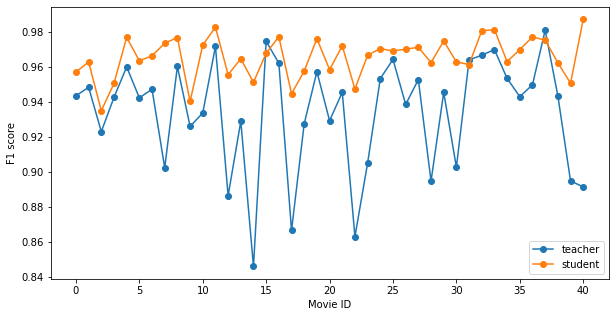

In [18]:
plt.figure(figsize=(10,5))
#plt.title('Comparison of F1 scores of all movies in teacher and student models')
plt.plot(np.arange(0,41), results_df.sort_values(by=['movie'])['f1'], label = "teacher", marker='o')
plt.plot(np.arange(0,41), stu_result_df.sort_values(by=['movie'])['f1'], label = "student", marker='o')
plt.legend(loc='lower right')
plt.xlabel('Movie ID')
#plt.xticks([])
plt.ylabel('F1 score')
plt.savefig('f1comparison.png')
plt.show()

In [19]:
stu_global_precision = stu_result_df['tp'].sum() / (stu_result_df['tp'].sum() + stu_result_df['fp'].sum())
stu_global_precision

0.9779874213836478

In [20]:
stu_global_recall = stu_result_df['tp'].sum() / (stu_result_df['tp'].sum() + stu_result_df['fn'].sum())
stu_global_recall

0.9551369454997948

In [21]:
stu_f1 = stu_result_df['f1'].mean()
stu_f1

0.9656340199044767

In [22]:
2*(stu_global_precision * stu_global_recall) / (stu_global_precision + stu_global_recall)

0.9664271315389406

In [23]:
results_df['f1'].mean()

0.9342789465064026

In [24]:
tea_global_precision = results_df['tp'].sum() / (results_df['tp'].sum() + results_df['fp'].sum())
tea_global_precision

0.9519844044667641

In [25]:
tea_global_recall = results_df['tp'].sum() / (results_df['tp'].sum() + results_df['fn'].sum())
tea_global_recall

0.917795346366775

In [26]:
tea_f1 = results_df['f1'].mean()
tea_f1

0.9342789465064026

In [27]:
2*(tea_global_precision * tea_global_recall) / (tea_global_precision + tea_global_recall)

0.9345773007155932

In [28]:
a1 = batch_predictions_df[batch_predictions_df['filename'] == '../test_data/125921-AnuJaMikko-1956.wav']

In [29]:
a1 = list(zip(a1['onset'],a1['offset']))

In [30]:
b1 = teacher_predictions_df[teacher_predictions_df['filename'] == '../test_data/125921-AnuJaMikko-1956.wav']

In [31]:
b1 = list(zip(b1['onset'],b1['offset']))

In [32]:
sbt = get_subtitles('125921-AnuJaMikko-1956')

In [33]:
student_times = []
for i, j in a1:
    if (660 >= i >= 600) and (660 >= j >= 600):
        print (i, j)
        student_times.append([i, j])

600.36 601.14
601.2 601.5600000000001
601.8000000000001 601.86
601.94 601.98
602.1800000000001 602.22
602.32 602.7
602.9 603.6
603.72 603.74
603.94 604.28
606.44 606.76
607.22 607.42
608.92 609.02
609.16 609.1800000000001
609.5600000000001 609.82
611.6 611.74
612.92 613.16
613.48 613.58
616.6800000000001 616.78
618.36 618.46
619.64 620.36
620.38 620.52
630.36 630.38
631.96 632.28
633.04 633.1
633.52 633.66
633.78 634.28
634.52 634.78
637.08 637.1
638.52 638.58
638.9 639.16
639.7 639.76
640.34 640.38
642.36 642.38
654.36 654.5600000000001
657.16 657.1800000000001
658.52 658.6800000000001


In [34]:
np.ones(len(student_times))

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.])

In [35]:
teacher_times= []
for i, j in b1:
    if (660 >= i >= 600) and (660 >= j >= 600):
        print (i, j)
        teacher_times.append([i, j])

605.62 607.5
607.78 607.84
608.2 610.44
610.46 611.32
611.36 612.74
612.8000000000001 613.92
614.26 618.96
619.04 620.76
622.08 629.22
629.38 635.42
635.58 637.6800000000001
638.0600000000001 643.32
643.92 644.28
644.42 645.54
645.86 646.76
646.98 647.1
652.4 658.84


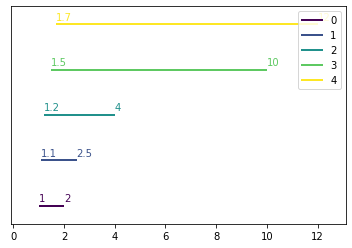

In [36]:
from matplotlib.lines import Line2D # Imported for legends
from matplotlib import collections  as mc
import pylab as pl

intervals = [(1, 2), (1.1, 2.5), (1.2, 4), (1.5, 10), (1.7, 12)]
num_intervals = len(intervals)
viridis = plt.cm.get_cmap('viridis', num_intervals)
colors = np.array([viridis(idx / num_intervals) for idx in range(len(intervals))])

# Prepare the input data in correct format for LineCollection 
lines = [[(i[0], j), (i[1], j)] for i, j in zip(intervals, range(len(intervals)))]

lc = mc.LineCollection(lines, colors= colors, linewidths=2)
fig, ax = pl.subplots()
ax.add_collection(lc)
ax.margins(0.1)
plt.yticks([], [])

# Adding the legends
def make_proxy(col, scalar_mappable, **kwargs):
    color = col 
    return Line2D([0, 1], [0, 1], color=color, **kwargs)
proxies = [make_proxy(c, lc, linewidth=2) for c in colors]
ax.legend(proxies, range(5))

# Adding annotations
for i, x in enumerate(intervals):
    plt.text(x[0], i+0.1, x[0], color=colors[i])
    plt.text(x[1], i+0.1, x[1], color=colors[i])

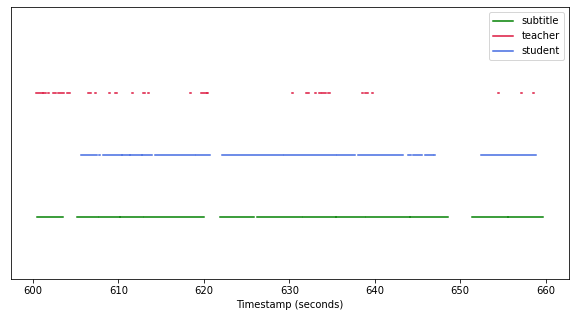

In [37]:
import matplotlib.pyplot as plt
import numpy as np
p = [item for item in student_times if  600.9 < max(item) < 660]
p2 = [item for item in teacher_times if  600.9 < max(item) < 660]
p3 = [item for item in sbt if  600.9 < max(item) <= 660]
plt.figure(figsize=(10,5))

def drawp(p, dy=1,**kw):
    for i,x in enumerate(p):
        plt.ylim(0, 1.1)
        plt.yticks([])
        plt.plot(np.unique(x),[dy]*len(np.unique(x)),
                 marker="s"*(2-len(np.unique(x))), ms=kw.get("lw",2),**kw)
        

drawp(p, color="crimson", dy = 0.75)
drawp(p2, color="royalblue", dy=0.5)
drawp(p3, color="green", dy=0.25)
plt.legend(["subtitle", "teacher", "student"])
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[0].set_color('green')
leg.legendHandles[1].set_color('crimson')
leg.legendHandles[2].set_color('royalblue')
plt.xlabel('Timestamp (seconds)')
#plt.title('Comparison of speech presence for a movie sample')
plt.savefig("comparison.png")
plt.show()